<span>
<img src="http://ash.readthedocs.io/en/latest/_static/ash.png" width="260px" align="right"/>
</span>
<span>
<b>Author:</b> <a href="https://andreafailla.github.io">Andrea Failla</a><br/>
<b>Python version:</b>  3.9<br/>
<b>ASH version:</b>  0.1.0<br/>
<b>Last update:</b> July 2025
</span>

<a id="attributed-stream-hypergraphs-ash"></a>
# Attributed Stream Hypergraphs (ASH)

In [68]:
#!pip install -e ../

<a id="table-of-contents"></a>
# Table of Contents

  - [Introduction](#introduction)
  - [Basic Concepts](#basic-concepts)
    - [What is a Hypergraph?](#what-is-a-hypergraph)
    - [What is an Attributed Stream Hypergraph?](#what-is-an-attributed-stream-hypergraph)
  - [Installation](#installation)
  - [Creating an ASH Instance](#creating-an-ash-instance)
  - [Populating an ASH](#populating-an-ash)
  - [Retrieving information from ASH](#retrieving-information-from-ash)
  - [Basic analysis](#basic-analysis)
- [Node Profiles](#node-profiles)
  - [Working with Statistics](#working-with-statistics)
  - [An algebra of node attributes](#an-algebra-of-node-attributes)

<a id="introduction"></a>
## Introduction

The ASH (Attributed Stream Hypergraph) is a powerful data structure for modeling temporal higher-order interactions. Unlike traditional graphs that connect pairs of nodes, hypergraphs can represent interactions among multiple entities simultaneously, and the ASH extends this concept to include temporal dynamics and rich attribute information.

This tutorial will guide you through the core concepts and practical usage of the ASH library.

[🔝 To top](#table-of-contents)

<a id="basic-concepts"></a>
## Basic Concepts

<a id="what-is-a-hypergraph"></a>
### What is a Hypergraph?

A hypergraph is a generalization of a graph where edges (called hyperedges) can connect any number of vertices, not just two. For example:
- In a regular graph: Alice → Bob (edge connects 2 nodes)
- In a hypergraph, apart from the case above, the following is also allowed: Alice, Bob, Charlie (hyperedge connects 3+ nodes)

[🔝 To top](#table-of-contents)

<a id="what-is-an-attributed-stream-hypergraph"></a>
### What is an Attributed Stream Hypergraph?

An ASH combines three key features:
1. **Hypergraph structure**: Edges can connect multiple nodes
2. **Temporal dynamics**: Hyperedges can appear and disappear over time
3. **Rich attributes**: Both nodes and hyperedges can have attributes, which can change over time

Consider a collaboration hypernetwork where:
- Nodes represent researchers
- Hyperedges represent papers written by two or more authors

This setting is adequately modeled with a hypergraph, as collaborations typically go beyond pairs of authors. With ASH, you can study how these collaborations evolve over time (e.g., year after year), as well as how attributes relate to/affect changes in topology. For instance, nodes/authors can be labeled with their main institution. As this affiliation changes over time, it is likely that the researcher's opportunities for collaboration change as well.

[🔝 To top](#table-of-contents)

ASHs can easily allow for the analyses, among others, of higher-order homophily, nodes’ homophily with respect to the hyperedges in which nodes participate, and time-respecting paths between hyperedges.

<a id="installation"></a>
## Installation
First, let's install the library. The easiest way to do so is via pip:

<code> pip install ash_model </code>

Then we can check that the library is installed by importing it:

[🔝 To top](#table-of-contents)

In [69]:
import ash_model

<a id="creating-an-ash-instance"></a>
## Creating an ASH Instance
The library has two main classes that users can interact with: 
- **ASH**, to create, manipulate, and work with attributed temporal hypergraphs
- **NProfile**, which is a high-level structure to model nodes and their attributes.

To instantiate an ASH, simply do:

[🔝 To top](#table-of-contents)

In [70]:
from ash_model import ASH
ash = ASH()

### Backend Selection

Since it is designed to work with complex temporal data, ASH offers two storage backends with different performance characteristics:

| Backend | Storage | Best For | Complexity |
|---------|---------|----------|------------|
| **Dense** (default) | time → set(hyperedge_ids) | Dense timelines, frequent snapshot queries | materialise: O(1), add: O(1) |
| **Interval** | hyperedge_id → [(start, end)] | Sparse temporal data, long-lived entities | materialise: O(N×log k), add: O(1) |

**Usage:**

```python
# Dense backend (default) - best for frequent queries
ash_dense = ASH()

# Interval backend - best for sparse temporal networks
ash_interval = ASH(backend="interval")
```

**When to use Interval backend:**
- Working with long-lived entities or hyperedges
- Sparse temporal data (few active times per entity)
- Memory-constrained environments
- Fewer snapshot queries compared to updates

**Technical Note:**  
The Interval backend uses two key optimizations:
1. **Binary search (bisect)**: O(log k) lookup per entity instead of O(k) linear scan, where k is the average number of intervals per entity
2. **Event-difference arrays**: O(1) updates for interval additions/removals using difference arrays, avoiding O(length) per-time loops

These optimizations provide ~10x performance improvements for interval-based operations while maintaining identical output to the Dense backend.

<a id="populating-an-ash"></a>
## Populating an ASH
You can add nodes to an ASH by using the corresponding methods:

[🔝 To top](#table-of-contents)

In [71]:
# Add a node present from time 0 to 5 (inclusive)
ash.add_node(node=1, start=0, end=5)

# Add a single node at time 0
ash.add_node(node=2, start=0) # This node is present at time 0 only

# Add a node with attributes
ash.add_node(node=3, start=0, end=2, attr_dict={"name": "Alice", "age": 25})

In [72]:
# Add multiple nodes at once
ash.add_nodes(nodes=[4, 5, 6], start=0, end=3)

# Add nodes with different attributes
node_attrs = {
    4: {"name": "Bob", "department": "CS"},
    5: {"name": "Charlie", "department": "Math"},
    6: {"name": "Diana", "department": "Physics"}
}

# this overrides the previous nodes
ash.add_nodes(nodes=[4, 5, 6], start=0, end=3, node_attr_dict=node_attrs)

A couple of things to note here:
- Most methods in ash have <code>start</code> and <code>end</code> parameters specifying temporal bounds. Both of these extremes are inclusive.
- Adding the same node(s) at times where it is already present overrides the previous configuration
- Adding the same node(s) to multiple time windows can be done by calling <code>add_node()</code> with the same <code>node_id</code> and different <code>start</code> and <code>end</code> parameters.

Adding hyperedges follows the same logic, it is as easy as:

In [73]:
# Add a hyperedge connecting nodes 1, 2, 3 at time 0
ash.add_hyperedge(nodes=[1, 2, 3], start=0)

# Add a hyperedge present from time 0 to 2
ash.add_hyperedge(nodes=[2, 3, 4], start=0, end=2)

# Add a hyperedge with attributes
ash.add_hyperedge(nodes=[1, 4, 5], start=1, end=3, weight=2.5, type="collaboration")

# Add multiple hyperedges with same time span
hyperedges = [[1, 2], [3, 4], [5, 6]]
ash.add_hyperedges(hyperedges, start=0, end=1, type="communication")

Similarly, nodes and hyperedges can be removed. This is often computationally expensive, so it is advised to use these operations sparingly and only when necessary.

In [74]:
# remove a hyperedge over all time spans
# ash.remove_hyperedge('e1')

# remove a node from a specific time span
# ash.remove_node(node=1, start=3)

# similarly, can remove in batch
# ash.remove_nodes(nodes=[2, 3], start=0, end=2)
# ash.remove_hyperedges(hyperedges=['e3', 'e2'], start=0, end=1)

<a id="retrieving-information-from-ash"></a>
## Retrieving information from ASH
Once an ASH is built, you can use some utilities to retrieve information from it. To access the times where it is active:

[🔝 To top](#table-of-contents)

In [75]:
ash.temporal_snapshots_ids()

[0, 1, 2, 3, 4, 5]

To access nodes:

In [76]:
for node in ash.nodes():
    # cycle through all nodes
    pass
for node in ash.nodes(start=0, end=3):
    # cycle through nodes present at time 0 to 3
    pass

To access edges:

In [77]:
for he in ash.hyperedges():
    # cycle through all hyperedges
    pass
for he in ash.hyperedges(start=0):
    # cycle through hyperedges present at time 0
    pass
for he in ash.hyperedges(hyperedge_size=2):
    # cycle through hyperedges with size 2
    print(he)

e5
e6
e4


As you can see, hyperedges are assigned a hyperedge id (string) at creation. To retrieve the actual sets of nodes you can do:

In [78]:
for he in ash.hyperedges(as_ids=False):
    pass
 
# or 
he_nodes = ash.get_hyperedge_nodes('e1') 

# conversely, to get the hyperedge id from a set of nodes:
he_id = ash.get_hyperedge_id(nodes=[1, 2, 3])

You can also stream all interactions. This yields activation and deactivation times of all edges:

In [79]:
for time, hedge_id, event in ash.stream_interactions():
    print(f"Time {time}: Hyperedge {hedge_id} was {event}")

Time 0: Hyperedge e1 was +
Time 0: Hyperedge e5 was +
Time 0: Hyperedge e6 was +
Time 0: Hyperedge e4 was +
Time 0: Hyperedge e2 was +
Time 1: Hyperedge e3 was +
Time 1: Hyperedge e1 was -
Time 2: Hyperedge e5 was -
Time 2: Hyperedge e6 was -
Time 2: Hyperedge e4 was -
Time 3: Hyperedge e2 was -
Time 4: Hyperedge e3 was -


Finally, you can check node and hyperedge presence at specific times:

In [80]:
# Check if node exists
has_node = ash.has_node(1, start=0, end=2)
print(f"Node 1 exists in time range [0,2]: {has_node}")

# Check if hyperedge exists
has_hyperedge = ash.has_hyperedge([1, 2, 3], start=1)
print(f"Hyperedge [1,2,3] exists at time 1: {has_hyperedge}")

Node 1 exists in time range [0,2]: True
Hyperedge [1,2,3] exists at time 1: False


In general, to get a specific node/hyperedge's temporal presence:

In [81]:
# Get presence of a node over time
node_presence = ash.node_presence(1)
print(f"Node 1 present at times: {node_presence}")

# Get presence as intervals
node_intervals = ash.node_presence(1, as_intervals=True)
print(f"Node 1 present in intervals: {node_intervals}")

# Hyperedge presence
hedge_id = ash.get_hyperedge_id([1, 2, 3])
hedge_presence = ash.hyperedge_presence(hedge_id, as_intervals=True)
print(f"Hyperedge present in intervals: {hedge_presence}")

Node 1 present at times: [0, 1, 2, 3, 4, 5]
Node 1 present in intervals: [(0, 5)]
Hyperedge present in intervals: [(0, 0)]


To retrieve information about attributes:

In [82]:
n_attrs = ash.list_node_attributes()
he_attrs = ash.list_hyperedge_attributes()
print(f"Node attributes: {n_attrs}")
print(f"Hyperedge attributes: {he_attrs}")

# Get node attributes
node_attrs = ash.get_node_attributes(5)
print(f"Node 5 attributes: {node_attrs}")

# Get hyperedge attributes
he_attrs = ash.get_hyperedge_attributes('e1')
print(f"Hyperedge attributes: {he_attrs}")

Node attributes: {'name': {'Alice', 'Charlie', 'Bob', 'Diana'}, 'age': {25}, 'department': {'Physics', 'CS', 'Math'}}
Hyperedge attributes: {'weight': {1, 2.5}, 'type': {'communication', 'collaboration'}}
Node 5 attributes: {0: {'name': 'Charlie', 'department': 'Math'}, 1: {'name': 'Charlie', 'department': 'Math'}, 2: {'name': 'Charlie', 'department': 'Math'}, 3: {'name': 'Charlie', 'department': 'Math'}}
Hyperedge attributes: {'weight': 1}


> **Note**: further information about handling node attributes is given in the Node Profile section below

<a id="basic-analysis"></a>
## Basic analysis
Here are some commonly used commands to extract information from ASH instances.

[🔝 To top](#table-of-contents)

In [83]:
# Get node's star (all hyperedges containing the node)
star = ash.star(1, start=0, end=2)
print(f"Node 1's star: {star}")

# Get node degree
degree = ash.degree(1, start=0, end=2)
print(f"Node 1's degree: {degree}")

# Get neighbors
neighbors = ash.neighbors(1, start=0, end=2)
print(f"Node 1's neighbors: {neighbors}")

# Degree by hyperedge size
degree_by_size = ash.degree_by_hyperedge_size(1, start=0, end=2)
print(f"Node 1's degree by size: {degree_by_size}")


Node 1's star: ['e1', 'e3', 'e4']
Node 1's degree: 3
Node 1's neighbors: {2, 3, 4, 5}
Node 1's degree by size: {3: 2, 2: 1}


In [84]:
# Network size
print(f"Number of nodes: {ash.number_of_nodes()}")
print(f"Number of hyperedges: {ash.number_of_hyperedges()}")

# Size distributions
hedge_size_dist = ash.hyperedge_size_distribution()
print(f"Hyperedge size distribution: {hedge_size_dist}")

degree_dist = ash.degree_distribution()
print(f"Degree distribution: {degree_dist}")


Number of nodes: 6
Number of hyperedges: 6
Hyperedge size distribution: {3: 3, 2: 3}
Degree distribution: {3: 4, 2: 1, 1: 1}


In [85]:
# Average statistics over time
avg_nodes = ash.avg_number_of_nodes()
avg_hyperedges = ash.avg_number_of_hyperedges()

print(f"Average nodes per snapshot: {avg_nodes:.2f}")
print(f"Average hyperedges per snapshot: {avg_hyperedges:.2f}")

# Coverage and uniformity
coverage = ash.coverage()
uniformity = ash.uniformity()

print(f"Coverage: {coverage:.2f}")
print(f"Uniformity: {uniformity:.2f}")

# Node contribution (fraction of time present)
node_contrib = ash.node_contribution(1)
print(f"Node 1 contribution: {node_contrib:.2f}")

# Hyperedge contribution
hedge_contrib = ash.hyperedge_contribution(hedge_id)
print(f"Hyperedge {hedge_id} contribution: {hedge_contrib:.2f}")


Average nodes per snapshot: 4.00
Average hyperedges per snapshot: 2.17
Coverage: 0.67
Uniformity: 0.74
Node 1 contribution: 1.00
Hyperedge e1 contribution: 0.17


<a id="node-profiles"></a>
# Node Profiles

The `NProfile` class is a high-level structure designed to model nodes and their attributes within the ASH framework. It provides a flexible way to store, manage, and analyze node attributes along with computed statistics.

[🔝 To top](#table-of-contents)

In [86]:
from ash_model import NProfile

# Create a profile without attributes and tie to a node ID
profile = NProfile(node_id=7)

# Create a profile with initial attributes
profile = NProfile(node_id=7, name="Edward", age=25, department="Math")
profile2 = NProfile(node_id=7, name="Edward", age=26, department="Math")
profile3 = NProfile(node_id=7, name="Edward", age=27, department="Physics")

for attr_name, attr_value in profile.items():
    print(f"Attribute {attr_name}: {attr_value}")

Attribute name: Edward
Attribute age: 25
Attribute department: Math


This profile can then be added to the ASH and retrieved subsequently

In [87]:
ash.add_node(node=7, start=0, attr_dict=profile)
ash.add_node(node=7, start=1, attr_dict=profile2)
ash.add_node(node=7, start=2, attr_dict=profile3)

To get the profile of a node at a specific time, simply do:

In [88]:
profile_t1 = ash.get_node_profile(7, tid=1)  # Retrieve the profile for node 7 at time 1

If you do not pass the <code>tid</code> parameter, an aggregated node profile is returned, where numerical values are averaged, and categorical values are substituted with the most frequent one.

In [89]:
aggregated_profile = ash.get_node_profile(7)  # Retrieve the aggregated profile for node 7
aggregated_profile.get_attributes() # Get all attributes of the profile

{'name': 'Edward', 'age': 26.0, 'department': 'Math'}

In case you need to access all profiles of a node over time:

In [90]:
ash.get_node_profiles_by_time(7)  # Get all profiles of node 7 over time

{0: <ash_model.classes.node_profile.NProfile at 0x130287c40>,
 1: <ash_model.classes.node_profile.NProfile at 0x130287ee0>,
 2: <ash_model.classes.node_profile.NProfile at 0x130164430>}

<a id="working-with-statistics"></a>
## Working with Statistics

One of the key features of `NProfile` is the ability to store computed statistics for attributes. This is particularly useful for temporal analysis where you might want to track how attributes change over time.

[🔝 To top](#table-of-contents)

In [91]:
profile = NProfile(node_id=1, name="Alice", age=25, department="CS")
# First, ensure the attribute exists
profile.add_attribute("publications", 15)

# Add statistics for the publications attribute
profile.add_statistic("publications", "mean", 12.5)
profile.add_statistic("publications", "max", 20)
profile.add_statistic("publications", "min", 5)
profile.add_statistic("publications", "std", 3.2)


In [92]:
# Get all statistics for an attribute
pub_stats = profile.get_statistic("publications")
print(pub_stats)  # Output: {'mean': 12.5, 'max': 20, 'min': 5, 'std': 3.2}

# Get a specific statistic
mean_pubs = profile.get_statistic("publications", "mean")
print(mean_pubs)  # Output: {'mean': 12.5}

# Check if a statistic exists
has_median = profile.has_statistic("publications", "median")
print(f"Has median: {has_median}")  # Output: Has median: False

# List all computed statistics for an attribute
stat_names = profile.attribute_computed_statistics("publications")
print(stat_names)  # Output: ['mean', 'max', 'min', 'std']

{'mean': 12.5, 'max': 20, 'min': 5, 'std': 3.2}
{'mean': 12.5}
Has median: False
['mean', 'max', 'min', 'std']


<a id="an-algebra-of-node-attributes"></a>
## An algebra of node attributes
`NProfile` objects can be compared using standard Python comparison operators:

[🔝 To top](#table-of-contents)

In [93]:
# Create two profiles with same attributes
profile1 = NProfile(node_id=1, name="Alice", age=25)
profile2 = NProfile(node_id=2, name="Alice", age=25)

# Equality is based on attributes, not node_id
print(profile1 == profile2)  # Output: True

# Different attributes
profile3 = NProfile(node_id=1, name="Alice", age=30)
print(profile1 == profile3)  # Output: False

True
False


For profiles with numeric attributes, you can use `>=` and `<=` operators:

In [94]:
# Create profiles with numeric attributes
researcher1 = NProfile(publications=10, citations=150, h_index=8)
researcher2 = NProfile(publications=8, citations=120, h_index=6)

# Check if researcher1 has >= values in all numeric attributes
print(researcher1 >= researcher2)  # Output: True

# Check if researcher2 has <= values in all numeric attributes
print(researcher2 <= researcher1)  # Output: True


True
True


In [6]:
from ash_model import viz

import networkx as nx
from ash_model import ASH
from ash_model.utils import from_networkx_maximal_cliques_list

snapshots = [nx.barabasi_albert_graph(100, 5) for _ in range(30)]
ash = from_networkx_maximal_cliques_list(snapshots)
print(ash)

Attributed Stream Hypergraph
Nodes: 100
Hyperedges: 8107
Snapshots: 30
Node attributes: 



In [3]:
from ash_model.viz.temporal import plot_node_activity_series, plot_hyperedge_activity_series, plot_presence_timeline, plot_inter_event_time_distribution, plot_hyperedge_lifespan_distribution


/Users/andreafailla/Documents/GitHub/ASH/ash_model/viz/temporal.py:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


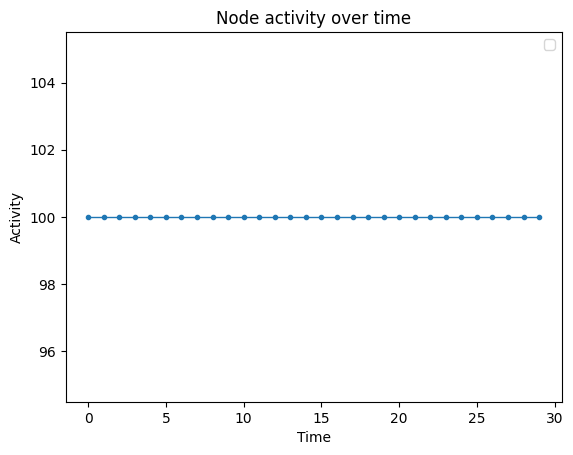

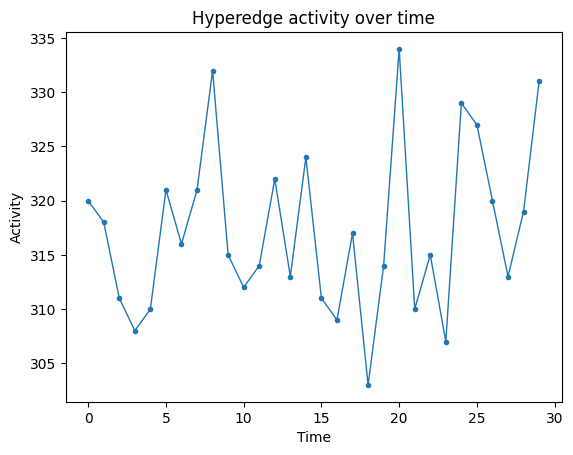

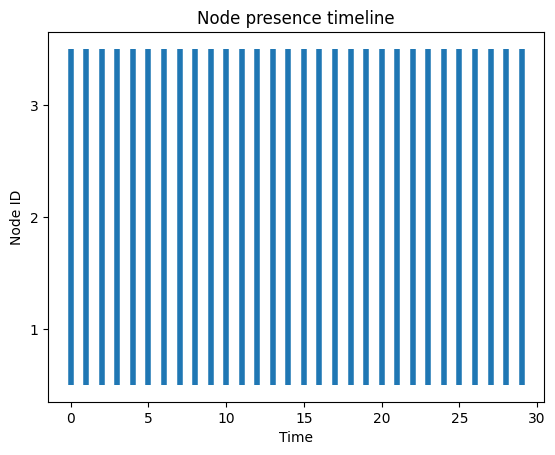

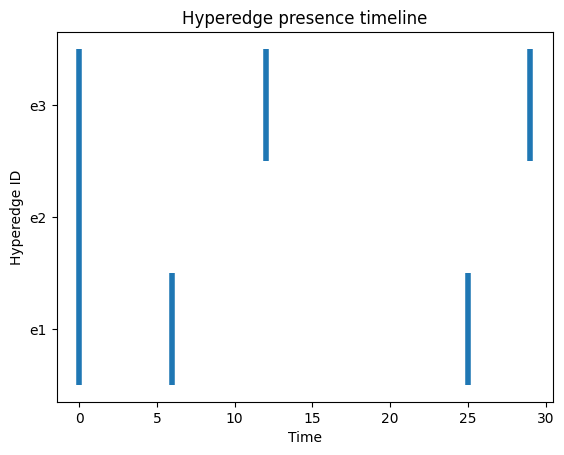

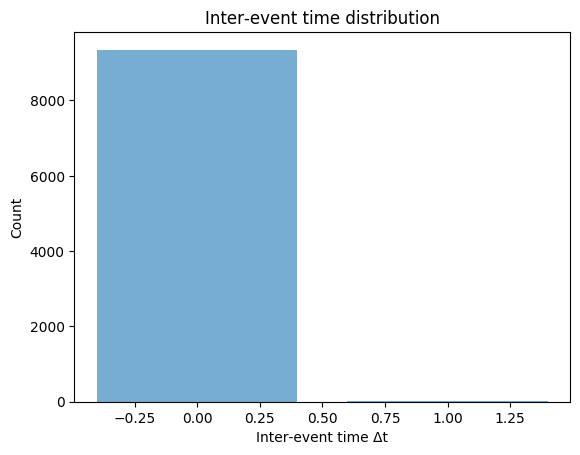

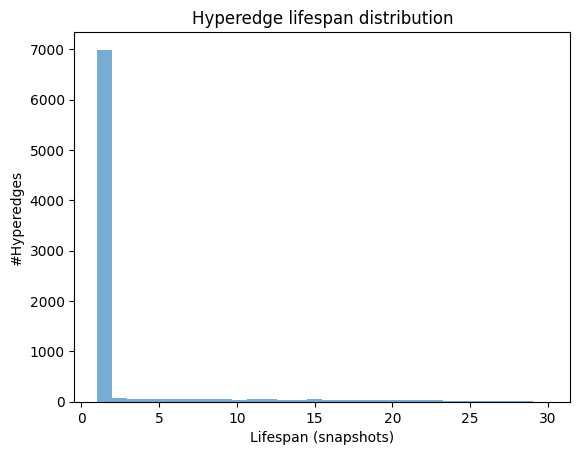

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.show()
plot_node_activity_series(ash)
plt.show()
plot_hyperedge_activity_series(ash)
plt.show()
plot_presence_timeline(ash, nodes=[1,2,3])
plt.show()
plot_presence_timeline(ash, hyperedges=['e1', 'e2', 'e3'])
plt.show()
plot_inter_event_time_distribution(ash)
plt.show()
plot_hyperedge_lifespan_distribution(ash)
plt.show()

